In [1]:
using Revise
using Plots, CSV, DataFrames, GLM, RollingFunctions
includet("model.jl")

┌ Info: Recompiling stale cache file /Users/evanmunro/.julia/compiled/v1.1/Revise/M1Qoh.ji for Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/evanmunro/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/evanmunro/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/evanmunro/.julia/compiled/v1.1/GLM/6OREG.ji for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/evanmunro/.julia/compiled/v1.1/RollingFunctions/ThWAA.ji for RollingFunctions [b0e4dd01-7b14-53d8-9b45-175a3e362653]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/evanmunro/.julia/compiled/v1.1/Combinatorics/AwRuT.ji for Combinatorics [861a8166-3701-5b0c-9a16-15d98fcdc6aa]
└ @ Base 

In [109]:
#xMap = Covariates(2)
xMap = Covariates([0.8,0.8],[0.06,0.48],[1,10000],2)

Covariates([0.8, 0.8], [0.06, 0.48], [1.0, 10000.0], 2)

In [93]:
x0,y0 = generate_sample(20,xMap)
data = convert(DataFrame,x0)
data[:y] = y0 
baseline_data= copy(data)
baseline = lm(@formula(y ~ x1+x2),data)

#ols = lm(@formula(y ~ 1),data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x1 + x2

Coefficients:
                Estimate Std.Error     t value Pr(>|t|)
(Intercept)  2.48253e-17  0.151787 1.63554e-16   1.0000
x1                  0.55   0.21996     2.50046   0.0229
x2                   0.2  0.191997     1.04168   0.3121


In [94]:
epochs = 20
N=5000
model = baseline 
mse = zeros(epochs)
mse[1] = mean((data[:y] .- predict(model,data)).^2) 
for t in 2:epochs
    x,y = generate_sample(N,xMap)
    data_new = convert(DataFrame,x)
    data_new[:y] = y 
    mse[t] = mean((data_new[:y] .- predict(model,data_new)).^2) 
    #update model for next time 
    data = vcat(data,data_new)
    model = lm(@formula(y ~ x1+x2),data)
end 

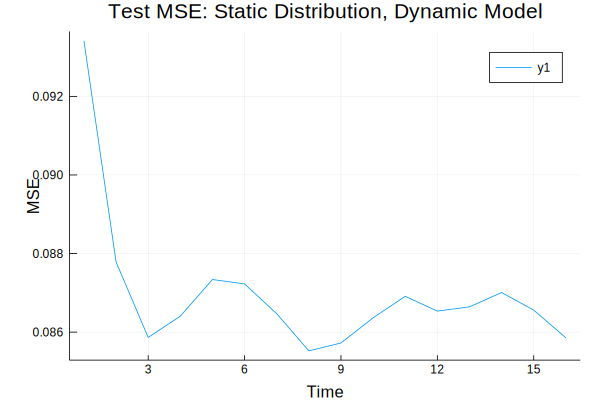

In [96]:
mse_stat = rollmean(mse[1:length(mse)],5)
plot(mse_stat,title="Test MSE: Static Distribution, Dynamic Model",xlabel="Time",ylabel="MSE")
#savefig("mse_stat_dyn.pdf")

In [104]:
epochs = 20
N=5000
model = baseline 
mse_dyn = copy(mse)
mse_dyn[1] = mean((data[:y] .- predict(model,data)).^2) 
for t in 2:epochs
    x,y = generate_sample(N,xMap)
    data_new = convert(DataFrame,x)
    data_new[:y] = y 
    mse_dyn[t] = mean((data_new[:y] .- predict(model,data_new)).^2) 
    #update model for next time 
    data = vcat(data,data_new)
    #model = lm(@formula(y ~ x1+x2),data)
end 



In [108]:
mse_dp = rollmean(mse_dyn[1:length(mse_dyn)],5)
plot([mse_stat,mse_dp],title="Rolling Out of Sample MSE",xlabel="Time",ylabel="MSE",label=["Update Model","Static Model"])
savefig("mse_stat.pdf")

In [20]:
model

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x1 + x2

Coefficients:
              Estimate   Std.Error t value Pr(>|t|)
(Intercept)  0.0289636 0.000385472 75.1379   <1e-99
x1            0.809615 0.000575815 1406.03   <1e-99
x2            0.103827 0.000511863 202.842   <1e-99
